In [1]:
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import maxentep
# disabling gpu for now
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
EPS = np.finfo(np.float32).tiny
param_batch_size = 1024
maxent_batch_size = 32
sns.set_context('notebook')

## Toy Model Example

### Make Joint

In [2]:
x = np.array([1., 1.])
i = tf.keras.Input((1,))
l = maxentep.TrainableInputLayer(x)(i)
d = tfp.layers.DistributionLambda(lambda x: tfd.Normal(loc=x[...,0], scale=tf.math.exp(x[...,1])))(l)

In [3]:
model = maxentep.ParameterJoint([lambda x: x], inputs=i, outputs=[d])
model.compile(tf.keras.optimizers.Adam(0.1))
model.summary()

Model: "parameter_joint"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
trainable_input_layer (Train (None, 2)                 2         
_________________________________________________________________
distribution_lambda (Distrib ((None,), (None,))        0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [4]:
model(tf.constant([1.]))

<tfp.distributions.Normal 'parameter_joint_distribution_lambda_Normal' batch_shape=[1] event_shape=[] dtype=float32>

In [5]:
def simulate(x):
    y = np.random.normal(loc=x, scale=0.1)
    return y

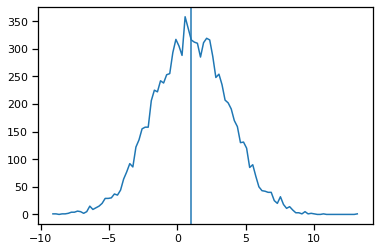

In [6]:
unbiased_params = model.sample(10000)
y = simulate(*unbiased_params)
grid,bins = np.histogram(y, bins=100)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.mean(np.squeeze(y)))

## Make Constraints

In [7]:
r = maxentep.Restraint(lambda x: x, -5, maxentep.EmptyPrior())

## Maxent without hyper training

In [8]:
me_model = maxentep.MaxentModel([r])
me_model.compile(tf.keras.optimizers.Adam(0.01), 'mean_squared_error')
result = me_model.fit(y, epochs=4)

Epoch 1/4
313/313 [==============================] - 0s 654us/step - loss: 7.1534 - weight-entropy: 2.1576
Epoch 2/4
313/313 [==============================] - 0s 670us/step - loss: 3.3730 - weight-entropy: 1.3396
Epoch 3/4
313/313 [==============================] - 0s 628us/step - loss: 2.8590 - weight-entropy: 1.0362
Epoch 4/4
313/313 [==============================] - 0s 636us/step - loss: 2.6669 - weight-entropy: 0.9049


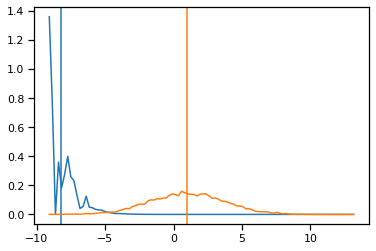

In [9]:
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid)
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

In [10]:
hme_model = maxentep.HyperMaxentModel([r], model, simulate)
hme_model.compile(tf.keras.optimizers.SGD(0.01), 'mean_squared_error')
result = hme_model.fit(epochs=4)

Epoch 1/4
8/8 [==============================] - 0s 875us/step - loss: 8.5806 - weight-entropy: 2.2026
Epoch 2/4
8/8 [==============================] - 0s 750us/step - loss: 3.3892 - weight-entropy: 1.5514
Epoch 3/4
8/8 [==============================] - 0s 625us/step - loss: 4.0383 - weight-entropy: 1.5366
Epoch 4/4
8/8 [==============================] - 0s 624us/step - loss: 3.9541 - weight-entropy: 1.3942
Epoch 1/4
8/8 [==============================] - 0s 625us/step - loss: 0.4916
Epoch 2/4
8/8 [==============================] - 0s 750us/step - loss: 0.4079
Epoch 3/4
8/8 [==============================] - 0s 625us/step - loss: 0.3993
Epoch 4/4
8/8 [==============================] - 0s 625us/step - loss: 0.3975
Epoch 1/4
8/8 [==============================] - 0s 750us/step - loss: 4.2313 - weight-entropy: 2.6362
Epoch 2/4
8/8 [==============================] - 0s 628us/step - loss: 1.0054 - weight-entropy: 2.7473
Epoch 3/4
8/8 [==============================] - 0s 624us/step - loss:

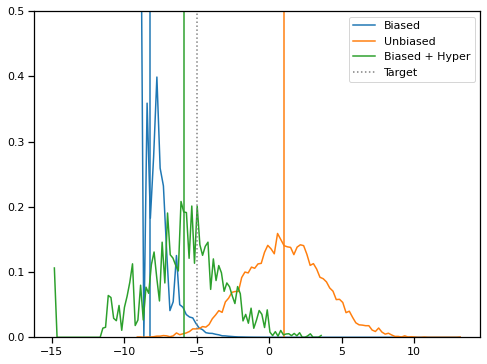

In [11]:
plt.figure(figsize=(8,6))
grid,bins = np.histogram(np.squeeze(y), bins=100, weights=me_model.traj_weights, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, label='Biased')
plt.axvline(np.sum(np.squeeze(y) * me_model.traj_weights))

grid,bins = np.histogram(np.squeeze(y), bins=100, density=True)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C1', label='Unbiased')
plt.axvline(np.mean(np.squeeze(y)), color='C1')

yp = np.squeeze(hme_model.trajs)
grid,bins = np.histogram(yp, bins=100, density=True, weights=hme_model.traj_weights)
plt.plot((bins[1:] + bins[:-1]) / 2, grid, color='C2', label='Biased + Hyper')
plt.axvline(np.sum(np.squeeze(yp) * hme_model.traj_weights), color='C2')

plt.axvline(x=r.target, color='Gray', linestyle=':', label='Target')
plt.ylim(0,0.5)
plt.legend()

## Examine Training Progress

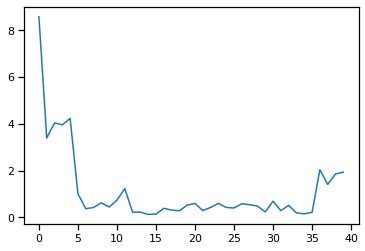

In [12]:
plt.plot(result.history['loss'])

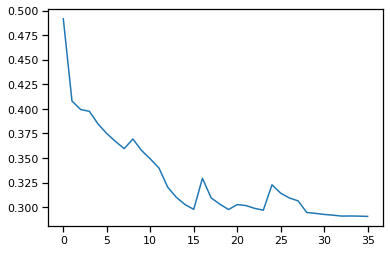

In [13]:
plt.plot(result.history['prior-loss'])

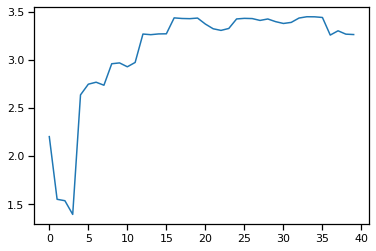

In [14]:
plt.plot(result.history['weight-entropy'])

## Set-up Starting Dist

In [15]:
M = 3
R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = R / np.sum(R, axis=1).reshape(M,1)
R, np.sum(R, axis=1)

(array([[0.49474306, 0.15034489, 0.35491205],
        [0.26588667, 0.40560941, 0.32850392],
        [0.32962952, 0.18815565, 0.48221482]]),
 array([1., 1., 1.]))

In [16]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 2)
tmat.add_transition('I', 'R', 14, 5)

In [17]:
start_logits = np.ones((M,))

## Set-up unbiased Joint

In [18]:
unbiased_model = maxentep.MetaParameterJoint(start_logits, R, tmat, name='unbiased')
unbiased_model(tf.constant([1.]))

[<tfp.distributions.Independent 'unbiased_model_R_dist_dist_Independentunbiased_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_T_dist_dist_Independentunbiased_model_T_dist_dist_unbiased_model_T_dist_dist_reciprocalunbiased_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'unbiased_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'unbiased_model_beta_dist_Independentunbiased_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

## Create Trainable Joint

In [19]:
model = maxentep.MetaParameterJoint(start_logits, R, tmat, name='param-model')

## Set-up loglikelihood

In [46]:
model.compile(tf.optimizers.Adam(1e-2))
model.summary()

Model: "param-model-model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
R-dist-hypers (TrainableInputLa (None, 2, 3, 3)      18          input_3[0][0]                    
__________________________________________________________________________________________________
R-dist-jitter (Lambda)          (None, 2, 3, 3)      0           R-dist-hypers[0][0]              
__________________________________________________________________________________________________
T-dist-hypers (TrainableInputLa (None, 2, 4, 4)      32          input_3[0][0]                    
__________________________________________________________________________________

## Test out the prior distributions

In [21]:
p = model(tf.constant([1.]))
p

[<tfp.distributions.Independent 'param_model_model_R_dist_dist_Independentparam_model_model_R_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3, 3] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>,
 <tfp.distributions.Blockwise 'param_model_model_rho_dist_dist_Blockwise' batch_shape=[] event_shape=[6] dtype=float32>,
 <tfp.distributions.Independent 'param_model_model_beta_dist_Independentparam_model_model_beta_dist_TruncatedNormal' batch_shape=[] event_shape=[1] dtype=float32>]

In [22]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [23]:
p[1].sample(2)
p[1].log_prob(p[1].sample(2))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([3.5020847, 5.614289 ], dtype=float32)>

In [24]:
s = [x.sample(2) for x in p]
print(s)

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
array([[[0.81075764, 0.43911058, 0.66820407],
        [0.4482813 , 1.227806  , 1.0110395 ],
        [0.11863804, 0.28514054, 0.7848043 ]],

       [[0.5073701 , 0.5463901 , 0.03872979],
        [0.39161807, 0.15740366, 0.03665254],
        [0.16427718, 0.69077945, 0.6245465 ]]], dtype=float32)>, <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.15350321, 0.12500264, 0.06568319],
       [0.36185768, 0.69286954, 0.09084448]], dtype=float32)>, <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[1.        , 0.        , 0.        , 0.05764359, 0.11733961,
        0.38602275],
       [0.        , 1.        , 0.        , 0.02888494, 0.11227179,
        0.19425195]], dtype=float32)>, <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.10220158],
       [0.09483306]], dtype=float32)>]


In [25]:
p[1].log_prob(s[1])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.1855745, 0.9192357], dtype=float32)>

In [26]:
p[1]

<tfp.distributions.Independent 'param_model_model_T_dist_dist_Independentparam_model_model_T_dist_dist_param_model_model_T_dist_dist_reciprocalparam_model_model_T_dist_dist_TruncatedNormal' batch_shape=[] event_shape=[3] dtype=float32>

In [27]:
[pi.log_prob(si) for pi, si in zip(p, s)]

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.5890248, -1.1352358], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4.1855745, 0.9192357], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.0535429, 1.1797154], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.1055472, 2.1279716], dtype=float32)>]

In [28]:
model.evaluate(tf.constant([1., 1.]), s)

1/1 [==============================] - 0s 2ms/step - loss: -6.0404 - R-dist-dist_loss: 1.8621 - T-dist-dist_loss: -2.5524 - rho-dist-dist_loss: -1.1166 - beta-dist_loss: -4.2335


[-6.040422439575195,
 1.8621305227279663,
 -2.5524051189422607,
 -1.1166290044784546,
 -4.233518600463867]

## Sampling Functions

In [29]:
v = model.sample(2)
v

[<tf.Tensor: shape=(2, 3, 3), dtype=float32, numpy=
 array([[[0.924636  , 0.43378806, 0.56198514],
         [0.20524473, 0.39787832, 0.9053464 ],
         [0.37037036, 0.849548  , 1.2122854 ]],
 
        [[0.24179968, 0.13859937, 0.41192552],
         [0.4972835 , 0.98816454, 1.1016369 ],
         [0.997352  , 0.43787464, 1.2570748 ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
 array([[[0.83940196, 0.16059801, 0.        , 0.        ],
         [0.        , 0.51370513, 0.48629487, 0.        ],
         [0.        , 0.        , 0.926384  , 0.07361606],
         [0.        , 0.        , 0.        , 1.        ]],
 
        [[0.85183257, 0.14816742, 0.        , 0.        ],
         [0.        , 0.7754504 , 0.22454958, 0.        ],
         [0.        , 0.        , 0.88306296, 0.11693706],
         [0.        , 0.        , 0.        , 1.        ]]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3, 4), dtype=float32, numpy=
 array([[[0.3217374 , 0.        , 0.        , 

c:\users\white\maxent\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explcit keyword will result in an error or misinterpretation.
  FutureWarning


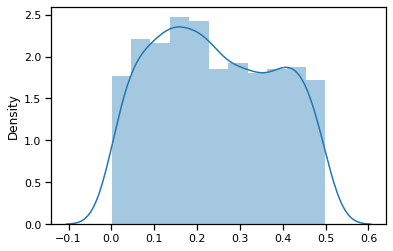

In [30]:
# sample start
s = model.sample(1000)[2].numpy().flatten()
sns.distplot(s[s > 0])

## Make some restraints

In [31]:
r1 = maxentep.Restraint(lambda x: x[...,25,0,2], 0.4, maxentep.EmptyPrior())
r2 = maxentep.Restraint(lambda x: x[...,50,0,2], 0.2, maxentep.EmptyPrior())

## Make Metapopulation Model

In [32]:
meta_model = maxentep.MetaModel(maxentep.contact_infection_func([1,2]), 150)

## Maxent Model

In [33]:
maxent_model = maxentep.MaxentModel([r1, r2])
maxent_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-2), 'mean_squared_error')

## Visualize Unbiased

Text(0.5, 1.0, 'Unbiased Result')

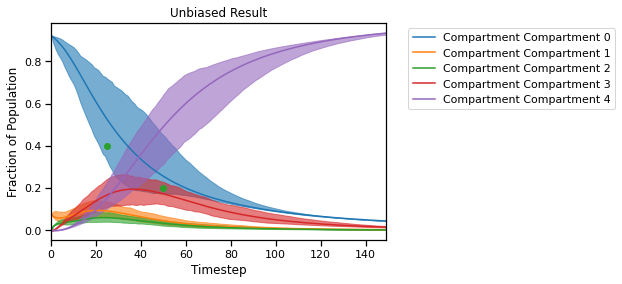

In [34]:
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
maxentep.traj_quantile(trajs[:,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Unbiased Result')

## Try to reweight without hyper-parameter tuning

In [35]:
me_loss = []
# sample and get batch
psample = unbiased_model.sample(param_batch_size)
trajs = meta_model(*psample)
# get weights of trajectories
h = maxent_model.fit(trajs, batch_size=maxent_batch_size, epochs=128, verbose=False)
me_loss.extend(h.history['loss'])
w = maxent_model.traj_weights

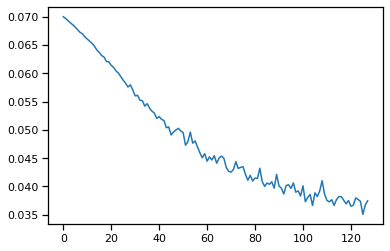

In [36]:
plt.plot(me_loss)
plt.show()

Text(0.5, 1.0, 'Maxent Result')

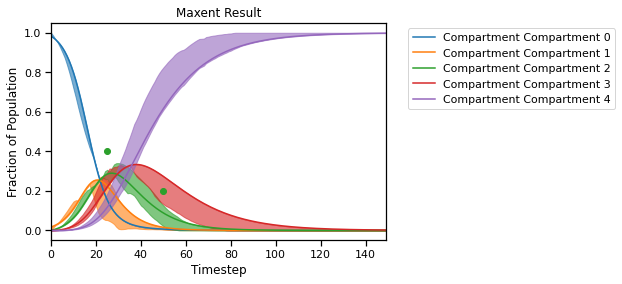

In [37]:
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result')

## Now tune hyperparameters at the same time

In [64]:
maxent_hyper_model = maxentep.HyperMaxentModel([r1, r2], model, meta_model, reweight=False)
maxent_hyper_model.compile(tf.keras.optimizers.SGD(learning_rate=1), 'mean_squared_error')
result = maxent_hyper_model.fit(param_batch_size, outter_epochs=100, batch_size=32, param_epochs=16, epochs=8)

Epoch 1/8
32/32 [==============================] - 0s 625us/step - loss: 0.0038 - weight-entropy: 3.4657
Epoch 2/8
32/32 [==============================] - 0s 625us/step - loss: 0.0038 - weight-entropy: 3.4657
Epoch 3/8
32/32 [==============================] - 0s 625us/step - loss: 0.0039 - weight-entropy: 3.4657
Epoch 4/8
32/32 [==============================] - 0s 687us/step - loss: 0.0038 - weight-entropy: 3.4657
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 0.0037 - weight-entropy: 3.4657
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 0.0039 - weight-entropy: 3.4657
Epoch 7/8
32/32 [==============================] - 0s 687us/step - loss: 0.0038 - weight-entropy: 3.4657
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 0.0037 - weight-entropy: 3.4657
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.

32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0496
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0049 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0496
Epoch 1/8
32/32 [==============================] - 0s 625us/step - loss: 0.0036 - weight-entropy: 3.4656
Epoch 2/8
32/32 [==============================] - 0s 656us/step - loss: 0.0036 - weight-entropy: 3.4656
Epoch 3/8
32/32 [==============================] - 0s 625us/step - loss: 0.0037 - weight-entropy: 3.4656
Epoch 4/8
32/32 [==============================] - 0s 687us/step - loss: 0.0036 - weight-entropy: 3.4656
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 0.0037 - weight-entropy: 3.4655
Epoch 6/8
32/32 [==============================] - 0s 594us/step - loss: 0.0035 - weight-entropy: 3.465

32/32 [==============================] - 0s 656us/step - loss: 0.0038 - weight-entropy: 3.4651
Epoch 2/8
32/32 [==============================] - 0s 610us/step - loss: 0.0037 - weight-entropy: 3.4651
Epoch 3/8
32/32 [==============================] - 0s 562us/step - loss: 0.0037 - weight-entropy: 3.4650
Epoch 4/8
32/32 [==============================] - 0s 563us/step - loss: 0.0037 - weight-entropy: 3.4650
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 0.0037 - weight-entropy: 3.4649
Epoch 6/8
32/32 [==============================] - 0s 531us/step - loss: 0.0036 - weight-entropy: 3.4649
Epoch 7/8
32/32 [==============================] - 0s 562us/step - loss: 0.0036 - weight-entropy: 3.4649
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 0.0036 - weight-entropy: 3.4648
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0053 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - bet

32/32 [==============================] - 0s 563us/step - loss: 0.0035 - weight-entropy: 3.4643
Epoch 4/8
32/32 [==============================] - 0s 594us/step - loss: 0.0034 - weight-entropy: 3.4642
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 0.0035 - weight-entropy: 3.4642
Epoch 6/8
32/32 [==============================] - 0s 563us/step - loss: 0.0034 - weight-entropy: 3.4641
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0036 - weight-entropy: 3.4641
Epoch 8/8
32/32 [==============================] - 0s 562us/step - loss: 0.0034 - weight-entropy: 3.4640
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0498
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.049

32/32 [==============================] - 0s 594us/step - loss: 0.0028 - weight-entropy: 3.4634
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0028 - weight-entropy: 3.4634
Epoch 8/8
32/32 [==============================] - 0s 563us/step - loss: 0.0029 - weight-entropy: 3.4633
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0055 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0055 - T-dist-dist_l

32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0499
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0054 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0022 - beta-dist_loss: -0.0500
Epoch 6/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0056 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0056 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0500
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0056 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0056 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0056 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 8/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0511 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0495
Epoch 6/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0511 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0495
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0495
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0495
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0495
Epoch 10/16
32/32 [==============================] - 0s 

32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 12/16
32/32 [==============================] - 0

32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0497
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0497
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0497
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0497
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0511 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 14/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0508 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0494
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0508 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0494
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0508 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0494
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0508 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0494
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0508 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0494
Epoch 14/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 14/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0510 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0496
Epoch 16/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0511
Epoch 14/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0511
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0511
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0511
Epoch 1/8
32/32 [==============================] - 0s 718us/step - loss: 0.0014 - weight-entropy: 3.4560
Epoch 2/8
32/32 [==============================] - 0s 719us/step - loss: 0.0014 - weight-entropy: 3.4561
Epoch 3/8
32/32 [=================

32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0050 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 1/8
32/32 [==============================] - 0s 562us/step - loss: 0.0012 - weight-entropy: 3.4545
Epoch 2/8
32/32 [==============================] - 0s 719us/step - loss: 0.0014 - weight-entropy: 3.4545
Epoch 3/8
32/32 [==============================] - 0s 594us/step - loss: 0.0012 - weight-entropy: 3.4543
Epoch 4/8
32/32 [==============================] - 0s 563us/step - loss: 0.0014 - weight-entropy: 3.4543
Epoch 5/8
32/32 [==============================] - 0s 562us/step - loss: 0.0015 - weight-entropy: 3.4544
Epoch 6/8
32/32 [==============================] - 0s 594us/step - loss: 0.0013 - weight-entropy: 3.454

32/32 [==============================] - 0s 625us/step - loss: 0.0012 - weight-entropy: 3.4553
Epoch 2/8
32/32 [==============================] - 0s 625us/step - loss: 0.0012 - weight-entropy: 3.4552
Epoch 3/8
32/32 [==============================] - 0s 562us/step - loss: 0.0012 - weight-entropy: 3.4552
Epoch 4/8
32/32 [==============================] - 0s 625us/step - loss: 0.0011 - weight-entropy: 3.4552
Epoch 5/8
32/32 [==============================] - 0s 656us/step - loss: 0.0011 - weight-entropy: 3.4552
Epoch 6/8
32/32 [==============================] - 0s 625us/step - loss: 0.0012 - weight-entropy: 3.4552
Epoch 7/8
32/32 [==============================] - 0s 594us/step - loss: 0.0010 - weight-entropy: 3.4551
Epoch 8/8
32/32 [==============================] - 0s 625us/step - loss: 0.0012 - weight-entropy: 3.4551
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0532 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0051 - rho-dist-dist_loss: -0.0024 - bet

32/32 [==============================] - 0s 625us/step - loss: 8.8361e-04 - weight-entropy: 3.4531
Epoch 5/8
32/32 [==============================] - 0s 687us/step - loss: 9.2338e-04 - weight-entropy: 3.4531
Epoch 6/8
32/32 [==============================] - 0s 687us/step - loss: 8.1958e-04 - weight-entropy: 3.4530
Epoch 7/8
32/32 [==============================] - 0s 656us/step - loss: 8.5602e-04 - weight-entropy: 3.4529
Epoch 8/8
32/32 [==============================] - 0s 594us/step - loss: 9.1593e-04 - weight-entropy: 3.4530
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0511 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0497
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0511 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0496
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0511 - R

32/32 [==============================] - 0s 562us/step - loss: 9.0903e-04 - weight-entropy: 3.4539
Epoch 8/8
32/32 [==============================] - 0s 562us/step - loss: 9.9774e-04 - weight-entropy: 3.4539
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0063 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0063 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0063 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0063 - T-dist-dist_loss: -0.0052 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0503
Epoch 5/16
32/32 [==========

32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0506
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0506
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0506
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0506
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0506
Epoch 6/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0523 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0510
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0523 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0510
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0523 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0510
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0523 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0510
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0522 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0509
Epoch 7/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0514 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0514 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0514 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0515 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0502
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0514 - R-dist-dist_loss: 0.0064 - T-dist-dist_loss: -0.0053 - rho-dist-dist_loss: -0.0023 - beta-dist_loss: -0.0501
Epoch 8/16
32/32 [==============================] - 0s 2

32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0501
Epoch 5/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0501
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0501
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0501
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0501
Epoch 9/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 2ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0509
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0509
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0509
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0508
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0509
Epoch 9/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0512
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0512
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0512
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0512
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0512
Epoch 10/16
32/32 [==============================] - 0s 

32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0518
Epoch 7/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0518
Epoch 8/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0518
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0518
Epoch 10/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0535 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0054 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0518
Epoch 11/16
32/32 [==============================] - 0s

32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0516 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 12/16
32/32 [==============================] - 0

32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0518 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0517 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0024 - beta-dist_loss: -0.0499
Epoch 12/16
32/32 [==============================] - 0

32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0506
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0506
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0506
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0506
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0055 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0506
Epoch 13/16
32/32 [==============================] - 

32/32 [==============================] - 0s 1ms/step - loss: -0.0531 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0531 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0056 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0509
Epoch 14/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0503
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0501
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0502
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0503
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0503
Epoch 14/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0514
Epoch 11/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0514
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0514
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0514
Epoch 14/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0514
Epoch 15/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 13/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 14/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0534 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0534 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 16/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 12/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0532 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0532 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 14/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0532 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0510
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0057 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0511
Epoch 16/16
32/32 [==============================] -

32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0501
Epoch 13/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0501
Epoch 14/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0501
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0501
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0500
Epoch 1/8
32/32 [==============================] - 0

32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0498
Epoch 14/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0498
Epoch 15/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0498
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0498
Epoch 1/8
32/32 [==============================] - 0s 594us/step - loss: 7.2924e-04 - weight-entropy: 3.4533
Epoch 2/8
32/32 [==============================] - 0s 656us/step - loss: 4.8794e-04 - weight-entropy: 3.4531
Epoch 3/8
32/32 [=========

32/32 [==============================] - 0s 2ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0507
Epoch 15/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0508
Epoch 16/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0025 - beta-dist_loss: -0.0508
Epoch 1/8
32/32 [==============================] - 0s 749us/step - loss: 6.2325e-04 - weight-entropy: 3.4550
Epoch 2/8
32/32 [==============================] - 0s 719us/step - loss: 5.6109e-04 - weight-entropy: 3.4549
Epoch 3/8
32/32 [==============================] - 0s 719us/step - loss: 6.6603e-04 - weight-entropy: 3.4550
Epoch 4/8
32/32 [==============================] - 0s 750us/step - loss: 8.4265e-04 - weight-entropy: 3.4551


32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 16/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0058 - T-dist-dist_loss: -0.0060 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 1/8
32/32 [==============================] - 0s 625us/step - loss: 8.8262e-04 - weight-entropy: 3.4546
Epoch 2/8
32/32 [==============================] - 0s 562us/step - loss: 6.4685e-04 - weight-entropy: 3.4548
Epoch 3/8
32/32 [==============================] - 0s 625us/step - loss: 5.8357e-04 - weight-entropy: 3.4548
Epoch 4/8
32/32 [==============================] - 0s 625us/step - loss: 6.4330e-04 - weight-entropy: 3.4549
Epoch 5/8
32/32 [==============================] - 0s 625us/step - loss: 7.7295e-04 - weight-entropy: 3.4550
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 6.5425e-04

32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0059 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 1/8
32/32 [==============================] - 0s 625us/step - loss: 5.1999e-04 - weight-entropy: 3.4537
Epoch 2/8
32/32 [==============================] - 0s 625us/step - loss: 7.8707e-04 - weight-entropy: 3.4538
Epoch 3/8
32/32 [==============================] - 0s 593us/step - loss: 5.7519e-04 - weight-entropy: 3.4538
Epoch 4/8
32/32 [==============================] - 0s 563us/step - loss: 7.5347e-04 - weight-entropy: 3.4537
Epoch 5/8
32/32 [==============================] - 0s 594us/step - loss: 6.7723e-04 - weight-entropy: 3.4538
Epoch 6/8
32/32 [==============================] - 0s 568us/step - loss: 7.4888e-04 - weight-entropy: 3.4537
Epoch 7/8
32/32 [==============================] - 0s 625us/step - loss: 5.3093e-04 - weight-entropy: 3.4537
Epoch 8/8
32/32 [==============================] - 0s 611

32/32 [==============================] - 0s 594us/step - loss: 8.8989e-04 - weight-entropy: 3.4547
Epoch 3/8
32/32 [==============================] - 0s 719us/step - loss: 6.7196e-04 - weight-entropy: 3.4549
Epoch 4/8
32/32 [==============================] - 0s 656us/step - loss: 8.4794e-04 - weight-entropy: 3.4548
Epoch 5/8
32/32 [==============================] - 0s 656us/step - loss: 7.2977e-04 - weight-entropy: 3.4549
Epoch 6/8
32/32 [==============================] - 0s 625us/step - loss: 7.2892e-04 - weight-entropy: 3.4551
Epoch 7/8
32/32 [==============================] - 0s 656us/step - loss: 7.8970e-04 - weight-entropy: 3.4550
Epoch 8/8
32/32 [==============================] - 0s 625us/step - loss: 6.7338e-04 - weight-entropy: 3.4550
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0061 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0510
Epoch 2/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 688us/step - loss: 7.8677e-04 - weight-entropy: 3.4556
Epoch 3/8
32/32 [==============================] - 0s 625us/step - loss: 6.7787e-04 - weight-entropy: 3.4555
Epoch 4/8
32/32 [==============================] - 0s 625us/step - loss: 7.6727e-04 - weight-entropy: 3.4556
Epoch 5/8
32/32 [==============================] - 0s 781us/step - loss: 8.7196e-04 - weight-entropy: 3.4556
Epoch 6/8
32/32 [==============================] - 0s 875us/step - loss: 8.5296e-04 - weight-entropy: 3.4556
Epoch 7/8
32/32 [==============================] - 0s 969us/step - loss: 6.8947e-04 - weight-entropy: 3.4557
Epoch 8/8
32/32 [==============================] - 0s 938us/step - loss: 7.1736e-04 - weight-entropy: 3.4556
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0532 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0504
Epoch 2/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 781us/step - loss: 8.5848e-04 - weight-entropy: 3.4567
Epoch 6/8
32/32 [==============================] - 0s 656us/step - loss: 9.0440e-04 - weight-entropy: 3.4568
Epoch 7/8
32/32 [==============================] - 0s 656us/step - loss: 7.9134e-04 - weight-entropy: 3.4568
Epoch 8/8
32/32 [==============================] - 0s 656us/step - loss: 7.6129e-04 - weight-entropy: 3.4568
Epoch 1/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0062 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0499
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0499
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0499
E

32/32 [==============================] - 0s 594us/step - loss: 7.7894e-04 - weight-entropy: 3.4569
Epoch 1/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 2/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0526 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 4/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0499
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0527 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0062 - 

32/32 [==============================] - 0s 1ms/step - loss: -0.0520 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0490
Epoch 3/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0490
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0489
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0519 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0490
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0520 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0062 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0490
Epoch 7/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0538 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0507
Epoch 4/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0538 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0507
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0538 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0507
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0538 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0507
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0537 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0027 - beta-dist_loss: -0.0507
Epoch 8/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0500
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0500
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0500
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0500
Epoch 8/16
32/32 [==============================] - 0s 2ms/step - loss: -0.0530 - R-dist-dist_loss: 0.0061 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0500
Epoch 9/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0495
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0495
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0495
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0525 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0495
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0524 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0495
Epoch 10/16
32/32 [==============================] - 0s 

32/32 [==============================] - 0s 1ms/step - loss: -0.0529 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0498
Epoch 5/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0529 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0498
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0529 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0498
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0529 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0498
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0529 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0498
Epoch 9/16
32/32 [==============================] - 0s 1

32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0536 - R-dist-dist_loss: 0.0059 - T-dist-dist_loss: -0.0063 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0506
Epoch 10/16
32/32 [==============================] - 0s 

32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0482
Epoch 6/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0513 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0483
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0483
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0513 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0483
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0512 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0483
Epoch 10/16
32/32 [==============================] - 0s 

32/32 [==============================] - 0s 1ms/step - loss: -0.0534 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0504
Epoch 7/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0534 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0504
Epoch 8/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0504
Epoch 9/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0503
Epoch 10/16
32/32 [==============================] - 0s 1ms/step - loss: -0.0533 - R-dist-dist_loss: 0.0060 - T-dist-dist_loss: -0.0064 - rho-dist-dist_loss: -0.0026 - beta-dist_loss: -0.0504
Epoch 11/16
32/32 [==============================] - 0s

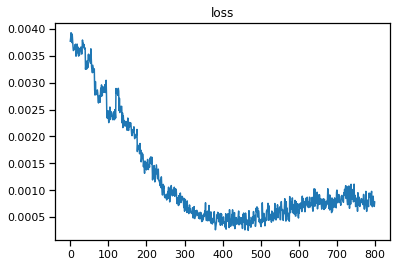

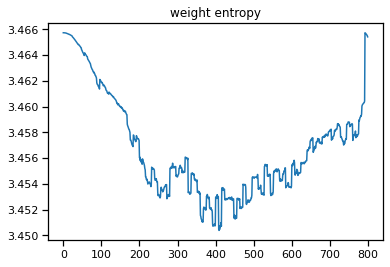

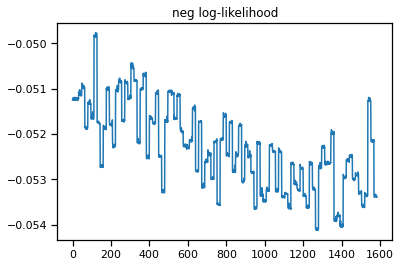

In [65]:
plt.plot(result.history['loss'])
plt.title('loss')
plt.show()

plt.plot(result.history['weight-entropy'])
plt.title('weight entropy')
plt.show()

plt.plot(result.history['prior-loss'])
plt.title('neg log-likelihood')
plt.show()

## Compare Weights

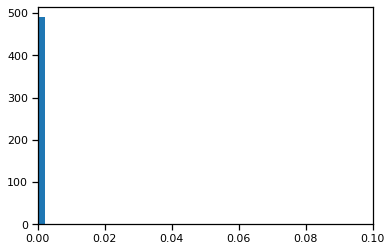

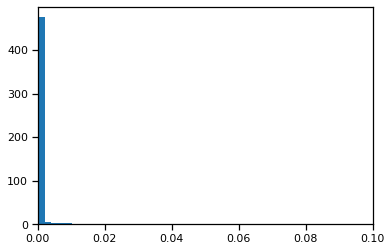

In [66]:
plt.hist(x=maxent_hyper_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()
plt.hist(x=maxent_model.traj_weights, bins=np.linspace(0,0.1,50), density=True)
plt.xlim(0,0.1)
plt.show()

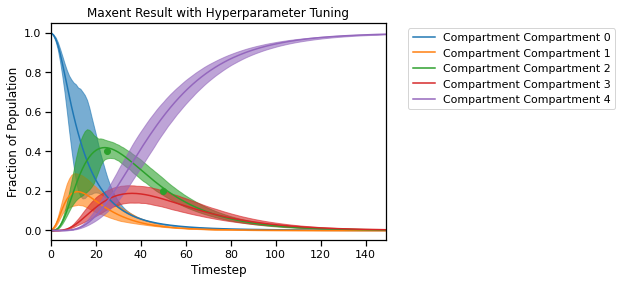

Text(0.5, 1.0, 'Maxent Result with Hyperparameter Tuning - Patch 2')

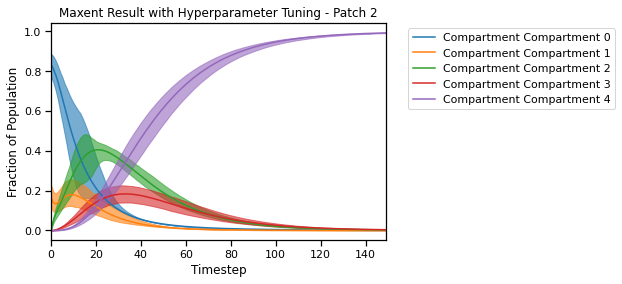

In [67]:
w = maxent_hyper_model.traj_weights
trajs = maxent_hyper_model.trajs
maxentep.traj_quantile(trajs[:,:,0,:], weights=w)
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Maxent Result with Hyperparameter Tuning')
plt.show()

maxentep.traj_quantile(trajs[:,:,2,:], weights=w)
plt.title('Maxent Result with Hyperparameter Tuning - Patch 2')

## Compare Hyper-parameter values

<BarContainer object of 32 artists>

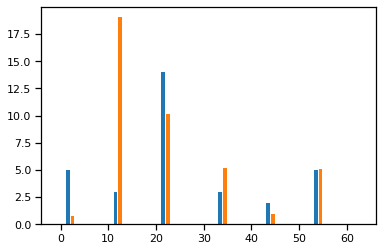

In [68]:
ub = unbiased_model.get_layer('T-dist-hypers').w.numpy().flatten()
b = model.get_layer('T-dist-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 3 artists>

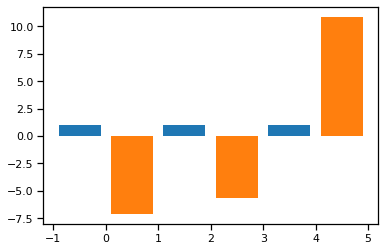

In [69]:
ub = unbiased_model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
b = model.get_layer('rho-dist-start-logit-hypers').w.numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

<BarContainer object of 2 artists>

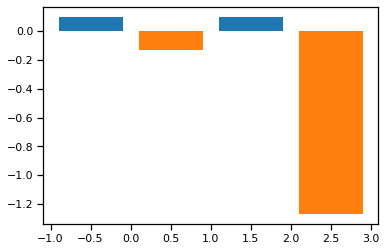

In [70]:
ub = unbiased_model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
b = model.get_layer('rho-dist-norm-hypers').trainable_variables[0].numpy().flatten()
plt.bar(np.arange(len(ub)) * 2 - 0.5, ub)
plt.bar(np.arange(len(ub)) * 2 + 0.5, b)

## Now compare with Directed regression

In [71]:
infect = maxentep.ContactInfectionLayer(0.1, tmat.infectious_compartments)
start = np.zeros((M, C))
start[0,0] = 0.2
reg_model = maxentep.TrainableMetaModel(start, R, tmat.value, infect, 100, lambda traj: (r1(traj)**2 + r2(traj)**2))

In [72]:
reg_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2))
reg_model.fit(epochs=1, verbose=True)

100/100 [==============================] - 4s 44ms/step - loss: 0.0281 - output_2_loss: 0.0281


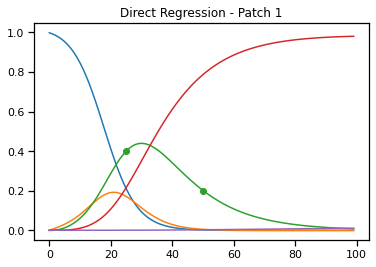

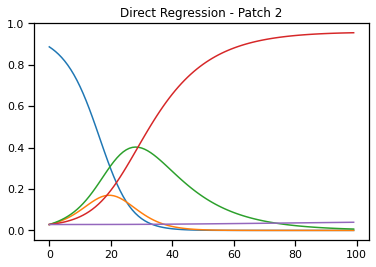

In [73]:
traj = reg_model.get_traj()
plt.plot(traj[0,:,0,:])
plt.plot(25, r1.target, 'o', color='C2')
plt.plot(50, r2.target, 'o', color='C2')
plt.title('Direct Regression - Patch 1')
plt.show()
traj = reg_model.get_traj()
plt.plot(traj[0,:,1,:])
plt.title('Direct Regression - Patch 2')
plt.show()

In [74]:
reg_model.summary()

Model: "trainable_meta_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_input_layer_1 (Tra multiple                  9         
_________________________________________________________________
trainable_input_layer_2 (Tra multiple                  16        
_________________________________________________________________
trainable_input_layer_3 (Tra multiple                  12        
_________________________________________________________________
metapop_layer_1 (MetapopLaye multiple                  1         
_________________________________________________________________
traj (AddSusceptibleLayer)   multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
Total params: 38
Trainable params: 38
Non-trainable params: 0
__________________________________________________

In [75]:
reg_model.layers[0].trainable_weights

[<tf.Variable 'value:0' shape=(3, 3) dtype=float32, numpy=
 array([[0.5083399 , 0.15878932, 0.33287078],
        [0.2911219 , 0.38542542, 0.32345262],
        [0.32633588, 0.26240653, 0.4112576 ]], dtype=float32)>]

In [76]:
reg_model.layers[1].trainable_weights

[<tf.Variable 'value:0' shape=(4, 4) dtype=float32, numpy=
 array([[7.6614320e-01, 2.3385680e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 9.3591452e-01, 6.4085469e-02, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 9.9982470e-01, 1.7527897e-04],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00]],
       dtype=float32)>]

In [77]:
reg_model.layers[2].trainable_weights

[<tf.Variable 'value:0' shape=(3, 4) dtype=float32, numpy=
 array([[8.80923035e-05, 1.20428784e-04, 8.05484247e-04, 8.05484829e-04],
        [2.85133384e-02, 2.85133421e-02, 2.85133403e-02, 2.85133440e-02],
        [5.04478766e-03, 5.04479837e-03, 5.04478067e-03, 5.04477927e-03]],
       dtype=float32)>]

In [78]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[8.80923035e-05, 1.20428784e-04, 8.05484247e-04, 8.05484829e-04],
       [2.85133384e-02, 2.85133421e-02, 2.85133403e-02, 2.85133440e-02],
       [5.04478766e-03, 5.04479837e-03, 5.04478067e-03, 5.04477927e-03]],
      dtype=float32)>

In [79]:
reg_model.layers[2].w.constraint.get_config

<bound method Constraint.get_config of <maxentep.metapop_model.MinMaxConstraint object at 0x00000244AA72F788>>

In [80]:
reg_model.layers[2].w.constraint(reg_model.layers[2].w)

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[8.80923035e-05, 1.20428784e-04, 8.05484247e-04, 8.05484829e-04],
       [2.85133384e-02, 2.85133421e-02, 2.85133403e-02, 2.85133440e-02],
       [5.04478766e-03, 5.04479837e-03, 5.04478067e-03, 5.04477927e-03]],
      dtype=float32)>